In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import librosa
from utils.initialise_weights import initialise_weights
from src.data_loader import *
from tqdm import tqdm
from utils.plot_to_tensorboard import plot_to_tensorboard
from utils.clear_folder import *
import torchshow as ts
import utils.plot_spectrograms as plot_spectrograms

# autoreload
%reload_ext autoreload
%autoreload 

In [2]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels=64, out_channels=64,kernel_size=5, stride=1,padding=2,requires_sum=True,generator=True):
        super(ConvBlock, self).__init__()
        self.requires_sum = requires_sum
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,stride=stride, padding='same' if generator else padding),
            nn.PReLU() if generator else nn.LeakyReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size,stride=stride, padding='same' if generator else 2) if self.requires_sum else nn.Identity()) # changed in_channels to out_channels 15 Jul 2023 @ 15:39:28
        
    def forward(self, x):
        if self.requires_sum is True:
            out = self.block(x)
            return x + out
        else:
            out = self.block(x)
            return out
        


class Generator(nn.Module):
    def __init__(self,in_channel=2, out_channel=64, blocks=4):
        super(Generator, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channel,kernel_size=11,stride=1,padding='same'),
            nn.PReLU()
        )

        self.blocks = nn.Sequential(*[ConvBlock() for _ in range(blocks)])
        self.conv = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,kernel_size=5,stride=1,padding='same')

        self.terminal = nn.Sequential(
            ConvBlock(in_channels=out_channel, out_channels=out_channel,requires_sum=False),
            ConvBlock(in_channels=out_channel, out_channels=out_channel,requires_sum=False),
            nn.Conv2d(in_channels=out_channel, out_channels=3,kernel_size=11,stride=1,padding='same')
        )

    def forward(self, z):
        # https://de.wikipedia.org/wiki/Arctan2
        z = self.initial(z)
        out = self.blocks(z)
        out = self.conv(out)
        out = out + z
        out = self.terminal(out)

        mag  = out[:,:1,:,:]
        phase = torch.arctan2(out[:,1:2,:,:], out[:,2:,:,:])
        out = torch.cat([mag, phase],dim=1)
        return out


class Critic(nn.Module):
    def __init__(self,in_channels=2,out_channels=32,in_features=2048,out_features=512,in_features_final=2048,blocks=2):
        super(Critic, self).__init__()
        self.initial = nn.Sequential(
            ConvBlock(in_channels=2, out_channels=64,stride=1,padding=2, generator=False,requires_sum=False)
        )
        # [f(x) if condition else g(x) for x in sequence]
        self.blocks = nn.Sequential(*[ConvBlock(in_channels=64, out_channels=64,stride=2,generator=False,requires_sum=False)  \
                                    if blocks == 0 else ConvBlock(in_channels=64, out_channels=64,stride=2,generator=False,requires_sum=False) \
                                    for _ in range(blocks)])
        self.terminal = nn.Sequential(
            nn.Flatten(-1,1),
            nn.Linear(in_features=64 * 32 * 32 ,out_features=1024),
            nn.LeakyReLU(),
            nn.Linear(in_features=1024,out_features=1),
            nn.Sigmoid()
        )


    def forward(self,x):
        x = self.blocks(self.initial(x))

        # print(x.shape)
        x = x.view(x.size(0), -1)

        # print(x.shape)
        x = self.terminal(x)



        return x.view(x.size(0), 1, 1, 1)


    @staticmethod
    def convert_to_complex(mag, angle):
        return mag*(np.cos(angle)+1j* np.sin(angle))

In [3]:
# Dimensionality Testing

x = torch.randn(4,1,128,128)
gen = Generator(1, 64, 4)
assert gen(x).shape == (4,2,128,128)
x = torch.randn(4,2,128,128)
critic = Critic(blocks=2)
assert critic(x).shape == (4,1,1,1)
print("Dimensionality Testing Passed")

Dimensionality Testing Passed


In [4]:
# Real Data Testing
# Data Loader

dataset = 0

if dataset:

    path = '../data/AudioMNIST_Indicies/dummy_labels.csv'
    root_dir = '../data/AudioMNIST/'

else:
    path = '../data/AvianID_AcousticIndices/UK_AI.csv'
    root_dir='../data/UK_BIRD/'

# 

ds = AvianNatureSounds(annotation_file=path,
                       root_dir=root_dir,
                       mel_spectrogram=None,
                       mode='stft',
                       key='habitat',
                       n_fft=2048,
                       hop_length=513,
                       max_ms=5000)
train_loader = DataLoader(dataset=ds, batch_size=1, shuffle=True)


ground_truth, input_mag, _ = next(iter(train_loader))

# Visual Testing
enable = False
if enable:
    plot_spectrograms.plot_spectrograms(ground_truth,magnitude=False)


# Generator Check
initialise_weights(gen)
gen = Generator(1, 64, 4)
fake = gen(input_mag)
assert fake.shape == ground_truth.shape





In [11]:
fake[:,:1,:,:] 

tensor([[[[-0.1672, -0.3283, -0.6752,  ...,  0.0593,  0.1715,  0.2691],
          [-0.0744, -0.3372, -0.5095,  ...,  0.1884,  0.3529,  0.4062],
          [-0.0055, -0.2449, -0.4035,  ...,  0.1190,  0.3027,  0.3001],
          ...,
          [-0.0922,  0.2385,  0.0399,  ...,  0.6924,  0.5815,  1.0570],
          [-0.2223,  0.1765,  0.3503,  ...,  0.6071,  0.4940,  0.7870],
          [-0.2456,  0.1719,  0.3310,  ...,  0.8923,  0.6823,  0.6477]]]],
       grad_fn=<SliceBackward0>)

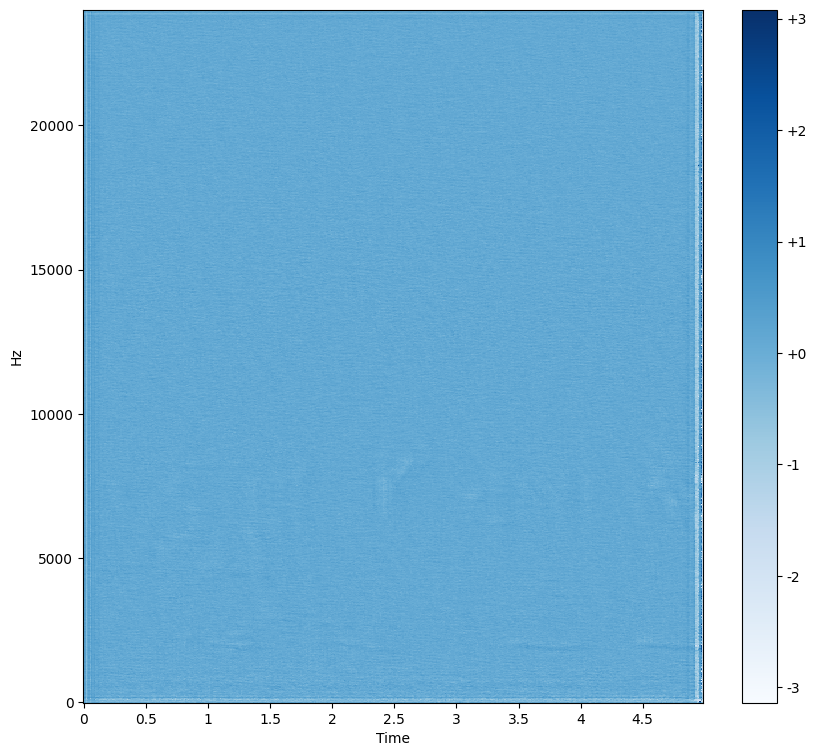

In [12]:
plot_spectrograms.plot_spectrograms(fake.detach(),magnitude=False)

In [6]:
# Hyperparameter
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cpu'

lr = 3e-4
batch_size = 128
img_sz = 64
channel_img = 1
epochs = 10
feature_disc = 64
feature_gen = 64
noise_dim = 100

In [7]:
gen = Generator(in_channel=1).to(device)
disc = Critic(blocks=2).to(device)

initialise_weights(gen)
initialise_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

criterion = nn.BCELoss()

fixed_noise = torch.randn(32, noise_dim,1,1).to(device)

writer_fake = SummaryWriter(f'../data/runs/SPhaseGAN/fake')
writer_real = SummaryWriter(f'../data/runs/SPhaseGAN/real')
writer = SummaryWriter(f'../data/runs/SPhaseGAN/log')
step = 0

gen.train()
disc.train()

Critic(
  (initial): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(2, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Identity()
      )
    )
  )
  (blocks): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Identity()
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Identity()
      )
    )
  )
  (terminal): Sequential(
    (0): Flatten(start_dim=-1, end_dim=1)
    (1): Linear(in_features=65536, out_features=1024, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=1024, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [8]:
def train():
    clear_folders('../data/runs/SPhaseGAN/fake/','../data/runs/SPhaseGAN/real/', '../data/runs/SPhaseGAN/log/')

    for epoch in range(epochs):
        loop = tqdm(train_loader, leave=False)
        for idx, (real_img, mag, _) in enumerate(loop):
            real_img = real_img.narrow(2, 0, 128).clone()
            real_img = real_img.to(device)

            magnitude = mag.narrow(2, 0, 128).clone()
            magnitude = magnitude.to(device)


            fake = gen(magnitude)

            ### Train Discriminator ###
            disc_real = disc(real_img)
            loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

            disc_fake = disc(fake)
            loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

            loss_disc = (loss_disc_real + loss_disc_fake) / 2
            disc.zero_grad()
            loss_disc.backward(retain_graph=True)
            opt_disc.step()

            ### Train Generator ###
            output = disc(fake)
            loss_gen = criterion(output, torch.ones_like(output))
            gen.zero_grad()
            loss_gen.backward()
            opt_gen.step()




            if idx == 0:
                print(
                    f'Epoch [{epoch / epochs}] \  '
                    f'Loss D: {loss_disc.item():.4f}, Loss G: {loss_gen.item():.4f}'
                )

    

            if idx % 50 == 0:
                plot_to_tensorboard(
                    writer = writer,
                    loss_critic = loss_disc.item(),
                    loss_gen = loss_gen.item(),
                    real = real_img,
                    fake = fake,
                    tb_step = step,
                    images = True
                )

                step += 1
                

                # with torch.no_grad():
                #     fake = gen(fixed_noise).reshape(-1, 1,64,64)
                #     data = real_img.reshape(-1, 1, 64, 64)

                #     img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                #     img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                #     writer_fake.add_image(
                #         'MNIST Fake Images', img_grid_fake, global_step=step
                #     )

                #     writer_real.add_image(
                #         'MNIST Real Images', img_grid_real, global_step=step
                #     )

                #     step += 1